**Objective of the competition:**

The competition dataset contains text from works of fiction written by spooky authors of the public domain: 
 1. Edgar Allan Poe (EAP)
 2. HP Lovecraft (HPL)
 3. Mary Wollstonecraft Shelley (MWS)
 
The objective  is to accurately identify the author of the sentences in the test set.

**Objective of the notebook:**

In this notebook, let us try to create different features that will help us in identifying the spooky authors. 

As a first step, we will do some basic data visualization and cleaning before we delve deep into the feature engineering part.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

/Users/sampathm/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


We can check the number of occurrence of each of the author to see if the classes are balanced. 

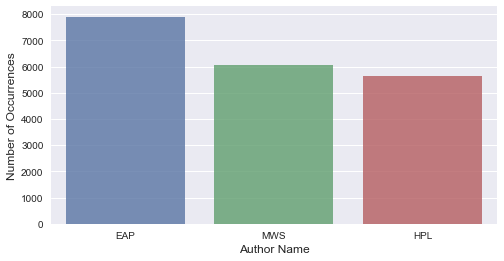

In [4]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

This looks good. There is not much class imbalance. Let us print some lines of each of the authors to try and understand their writing style if possible.

In [5]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

Only thing I can see is that there are quite a few special characters present in the text data. So count of these special characters might be a good feature. Probably we can create them later.

Apart from that, I do not have much clue.. In case if you find any interesting styles (features which we can create), please add them in the comments. 

**Feature Engineering:**

Now let us come try to do some feature engineering. This consists of two main parts.

 1. Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
 2. Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

**Meta Features:**

We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords 
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words


In [43]:
feature_engg_config = [
    {
        "name": "num_words",
        "columns": "text",
        "func": lambda x: len(str(x).split())
    }, {
        "name": "num_unique_words",
        "columns": "text",
        "func": lambda x: len(set(str(x).split()))
    }, {
        "name": "num_chars",
        "columns": "text",
        "func": lambda x: len(str(x))
    }, {
        "name": "num_stopwords",
        "columns": "text",
        "func": lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords])
    }, {
        "name": "num_words_upper",
        "columns": "text",
        "func": lambda x: len([w for w in str(x).split() if w.isupper()])
    }, {
        "name": "num_words_title",
        "columns": "text",
        "func": lambda x: len([w for w in str(x).split() if w.istitle()])
    }, {
        "name": "mean_word_len",
        "columns": "text",
        "func": lambda x: np.mean([len(w) for w in str(x).split()])
    }, {
        "name": "count_quotes",
        "columns": "text",
        "func": lambda x: (x.lower().count('"') or x.lower().count("'"))
    }, {
        "name": "count_comma",
        "columns": "text",
        "func": lambda x: x.count(',')
    }, {
        "name": "num_punctuations",
        "columns": "text",
        "func": lambda x: len([c for c in str(x) if c in string.punctuation])
    }

]

In [45]:
for fe in feature_engg_config:
    if fe['name']:
        train_df[fe['name']] = train_df[fe['columns']].map(fe['func'])
        test_df[fe['name']] = train_df[fe['columns']].map(fe['func'])

Let us now plot some of our new variables to see of they will be helpful in predictions.

EAP seems slightly lesser number of words than MWS and HPL. 

This also seems to be somewhat useful. Now let us focus on creating some text based features. 

Let us first build a basic model to see how these meta features  are helping. 

In [46]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

We can train a simple XGBoost model. 

## MODELLING

In [47]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2500

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

For the sake of kernel run time, we can just check the first fold in the k-fold cross validation for the scores. Please remove the 'break' line while running in local.

In [48]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09132	test-mlogloss:1.09259
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.02375	test-mlogloss:1.03487
[40]	train-mlogloss:0.996519	test-mlogloss:1.01157
[60]	train-mlogloss:0.981981	test-mlogloss:1.00122
[80]	train-mlogloss:0.970882	test-mlogloss:0.992818
[100]	train-mlogloss:0.961152	test-mlogloss:0.986491
[120]	train-mlogloss:0.953363	test-mlogloss:0.98157
[140]	train-mlogloss:0.947868	test-mlogloss:0.978764
[160]	train-mlogloss:0.941695	test-mlogloss:0.975699
[180]	train-mlogloss:0.937192	test-mlogloss:0.973984
[200]	train-mlogloss:0.932492	test-mlogloss:0.971846
[220]	train-mlogloss:0.927483	test-mlogloss:0.969162
[240]	train-mlogloss:0.923035	test-mlogloss:0.967162
[260]	train-mlogloss:0.919033	test-mlogloss:0.965991
[280]	train-mlogloss:0.915217	test-mlogloss:0.964404
[300]	train-mlogloss:0.912019	test-mlogloss:0.963584
[320]	train-ml

We are getting a mlogloss of '0.987' using just the meta features. Not a bad score. Now let us see which of these features are important.

In [49]:
model.feature_names

['num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_words_upper',
 'num_words_title',
 'mean_word_len',
 'count_quotes',
 'count_comma',
 'num_punctuations']

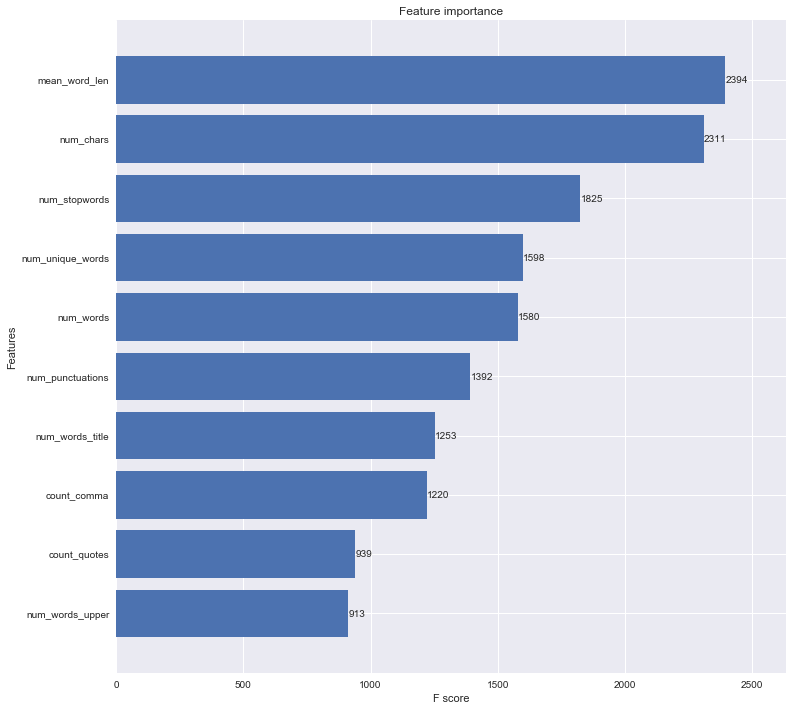

In [50]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, # max_num_features=50,
                    height=0.8, ax=ax)
plt.show()

Number of characters, mean word length and number of unique words turn out to be the top 3 variables. Now let us focus on creating some text based features. 

**Text Based Features :**

One of the basic features which we could create is tf-idf values of the words present in the text. So we can start with that one.


In [51]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

Now that we have got the tfidf vector, here is the tricky part. The tfidf output is a sparse matrix and so if we have to use it with other dense features, we have couple of choices. 
1. We can choose to get the top 'n' features (depending on the system config) from the tfidf vectorizer, convert it into dense format and concat with other features. 
2. Build a model using just the sparse features and then use the predictions as one of the features along with other dense features.

Based on the dataset, one might perform better than the other. Here we can use the second approach since there are some very [good scoring kernels](https://www.kaggle.com/the1owl/python-tell-tale-tutorial) using all the features of tfidf.

Also it seems that, [Naive Bayes is performing better](https://www.kaggle.com/thomasnelson/spooky-simple-naive-bayes-scores-0-399) in this dataset. So we could build a naive bayes model using tfidf features as it is faster to train.

In [52]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

**Naive Bayes on Word Tfidf Vectorizer:**

In [53]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.842216198361


We are getting a mlogloss of 0.844 using just tfidf vectorizer. Much better than the meta features. We can now create frequency features and see how it is performing.

**SVD on word TFIDF:**

Since the tfidf vectors are sparse, one another way of compressing the information and representing it in a much compact way is through SVD. Also generally SVD features have performed well for me in the past text based competitions. So we could created svd features on word tfidf and add them to our feature set.

In [64]:
TruncatedSVD?

In [54]:
n_comp = 10 # 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**Naive Bayes on Word Count Vectorizer:**

In [55]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

Now let us build Multinomial NB model using count vectorizer based features..

In [56]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]



Mean cv score :  0.450918416166


Wow. We got a cross validation mlogloss of 0.451 using count vectorizer inplace of tfidf vectorizer. LB score using this model is 0.468. 

** Naive Bayes on Character Count Vectorizer:**

One idea from the "data eyeballing" is that counting the special charaters might help. Instead of just counting the special characters, we can use the count vectorizer at character level to get some features. Again we can run Multinomial NB on top of it.

In [57]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.75076392268


The cross val score is very high and is 3.75. But this might add some different information than word level features and so let us use this for the final model as well.

**Naive Bayes on Character Tfidf Vectorizer:**

Let us also get the naive bayes predictions on the character tfidf vectorizer.

In [58]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947


**SVD on Character TFIDF:**

We could also create svd features on character tfidf features and used them for modeling.

In [59]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

**XGBoost model:**

Now with these new variables, we can re-run the xgboost model and evaluate the results.

In [60]:
train_X.head(5)

,num_words,num_unique_words,num_chars,num_stopwords,num_words_upper,num_words_title,mean_word_len,count_quotes,count_comma,num_punctuations
0,41,35,231,19,2,3,4.658537,0,4,7
1,14,14,71,8,0,1,4.142857,0,0,1
2,36,32,200,16,0,1,4.583333,0,4,5
3,34,32,206,13,0,4,5.088235,0,3,4
4,27,25,174,11,0,2,5.481481,0,2,4


In [61]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.75)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
    
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:1.00246	test-mlogloss:1.00238
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.412358	test-mlogloss:0.417496
[40]	train-mlogloss:0.340172	test-mlogloss:0.353017
[60]	train-mlogloss:0.314764	test-mlogloss:0.334965
[80]	train-mlogloss:0.297126	test-mlogloss:0.325003
[100]	train-mlogloss:0.282545	test-mlogloss:0.318742
[120]	train-mlogloss:0.271337	test-mlogloss:0.314485
[140]	train-mlogloss:0.26128	test-mlogloss:0.312499
[160]	train-mlogloss:0.252273	test-mlogloss:0.309734
[180]	train-mlogloss:0.243841	test-mlogloss:0.308281
[200]	train-mlogloss:0.236128	test-mlogloss:0.306525
[220]	train-mlogloss:0.228405	test-mlogloss:0.30522
[240]	train-mlogloss:0.222184	test-mlogloss:0.305175
[260]	train-mlogloss:0.215772	test-mlogloss:0.304721
[280]	train-mlogloss:0.209926	test-mlogloss:0.304488
[300]	train-mlogloss:0.20428	test-mlogloss:0.304432
[320]	train-

**This has a val score of 0.3055 and LB score of 0.3xxx** Running it on all the folds might give a better score. Now let us check the important variables again.

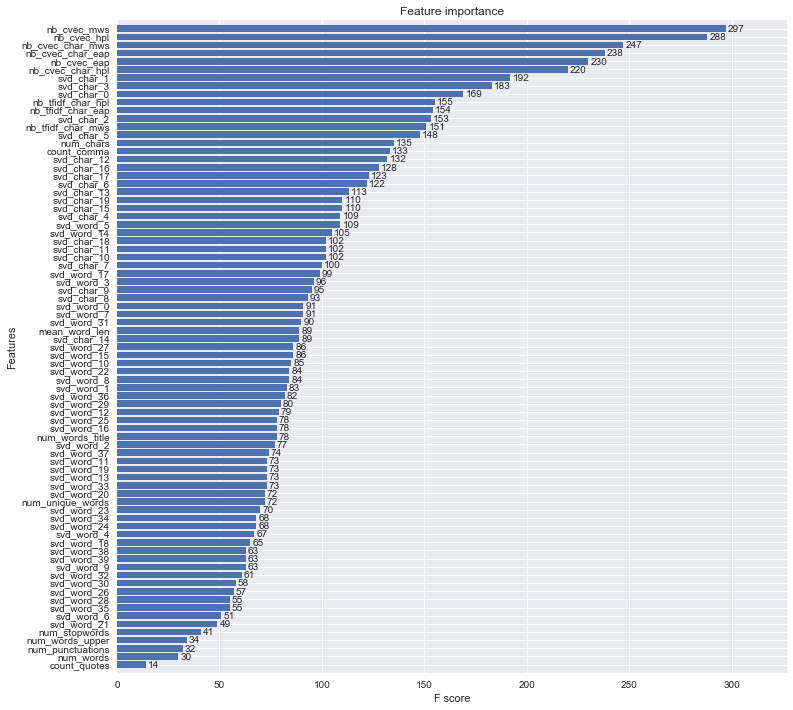

In [62]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, # max_num_features=50,
                    height=0.8, ax=ax)
plt.show()

Naive bayes features are the top features as expected. Now let us get the confusion matrix to see the misclassification errors.

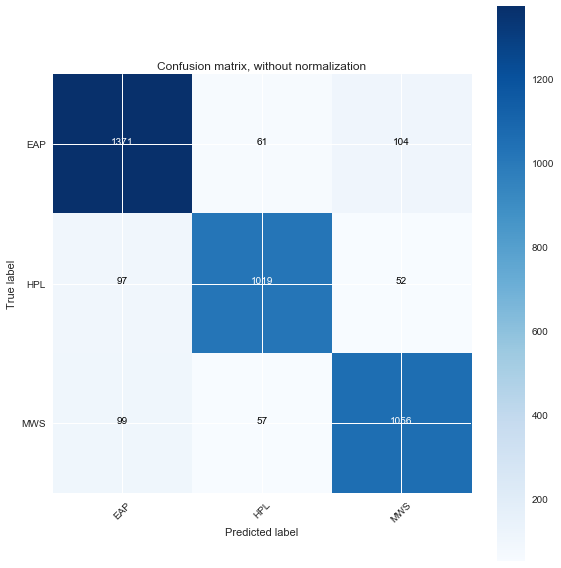

In [63]:
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

EAP and MWS seem to be misclassified more often than others. We could potentially create features which improves the predictions for this pair.

**Next steps in this FE notebook:**
* Using word embedding based features 
* Other meta features if any

**Ideas for further improvements:**
* Parameter tuning for tfidf and count vectorizer
* Parameter tuning for naive bayes and XGB models
* Ensembling / Stacking with other models


**More to come. Stay tuned.!**